In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns

import sqlite3

import pickle, joblib

<br>

## Data Load

In [4]:
connection = sqlite3.connect('../input/twitter-airline-sentiment/database.sqlite')
query = "SELECT * FROM sqlite_master"
db = pd.read_sql_query(sql = query, con = connection)
db

,type,name,tbl_name,rootpage,sql
0,table,Tweets,Tweets,2,CREATE TABLE Tweets (\n tweet_id INTEGER PR...


In [5]:
query = "SELECT airline, text, negativereason, airline_sentiment AS sentiment FROM 'Tweets'"

df = pd.read_sql_query(sql = query, con = connection)

display(df.shape, df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airline         14485 non-null  object
 1   text            14485 non-null  object
 2   negativereason  14485 non-null  object
 3   sentiment       14485 non-null  object
dtypes: object(4)
memory usage: 452.8+ KB


(14485, 4)

,airline,text,negativereason,sentiment
0,Delta,@JetBlue's new CEO seeks the right balance to ...,,neutral
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative


None

<br> 

* **`airline`** : Does not contain null data. I will add this feature in stopwords.
* **`name`** : Will add this feature in stopwords.
* **`text`** : Does not contain null data. Every text begins with @ due to the characteristic of twitter. In addition, we can see emoji on the text.
* **`negativereason`** : Blank if `sentiment` is not ''negative.
* **`alirline_sentiment`** : Does not contain null data.

<br>

## EDA

### Total count per Airlines

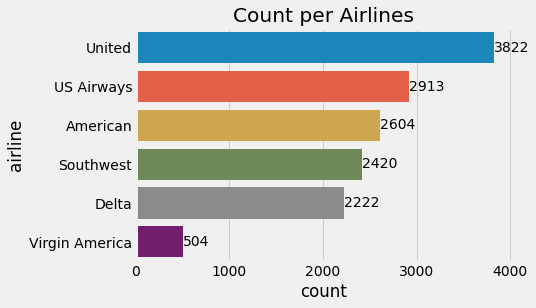

In [4]:
ax = sns.countplot(data = df, y = 'airline',
                   order = df.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)
                                    
plt.show()

<br>

### Proportion of Sentiments

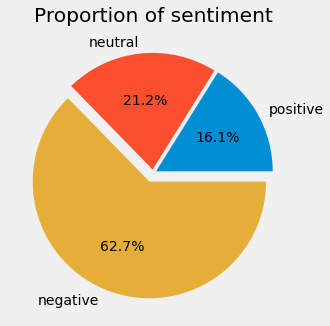

In [5]:
x = df.sentiment.value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

In [6]:
a = df.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [ ]:
# b = sorted(list(dict(df.airline.value_counts()).items()), key = lambda x : x[0])
# print(b)

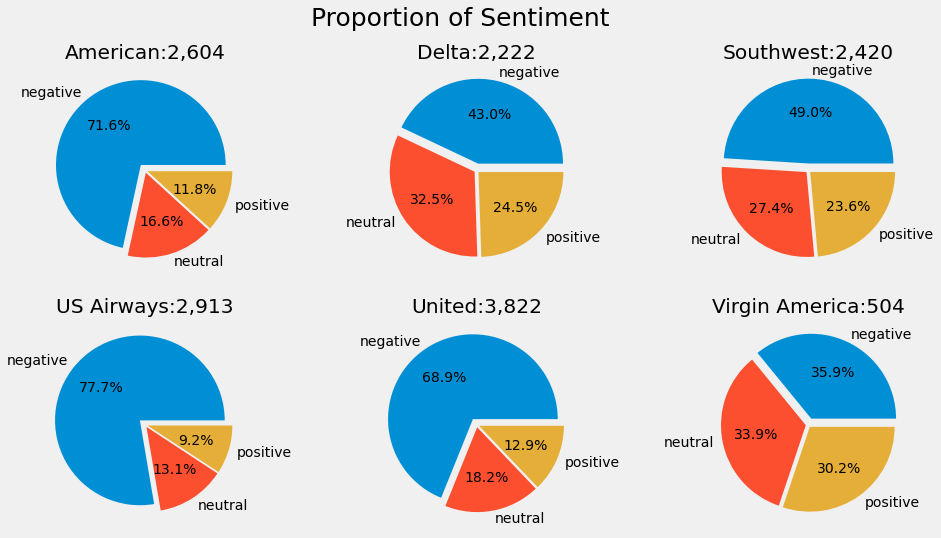

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("Proportion of Sentiment", fontsize = 25)    
plt.show()

<br>

I think it is interesting to compare the twitter data with another real data to check the coherence of the customer's sentiment to each airlines.

<br>

**[The overall performances of the largest U.S. airlines on the Middle Seat scorecard, from 2015 to 2017]**

<img src='https://si.wsj.net/public/resources/images/BN-WX851_backgr_4U_20180110102611.jpg'>


<source: https://www.wsj.com/articles/the-best-and-worst-airlines-of-2017-1515594783>

<br>

* **`American`**, **`US Airways`**: American airlines merged US Airways on 2015. Coincidentally or not, the sentiment for these two airlines shows negative in general. In addtion, the above overall performances from 2015 to 2017 explain it is somewhat reasonable to feel negative to them.

* **`United`**: 68.9% of people felt it negative.

* **`Delta`**, **`Southwest`**: Better than `American` and `US Airways` as the proportion of negative sentiment is less than 50%.

* **`Virgin America`**: The proportion of sentiments is very well-balanced, but the count is not as many as the other's one. It has been merged with Alaska on 2017. 

<br>

### Reason for Negative sentiment

In [8]:
print(df.negativereason.unique())

['' "Can't Tell" 'Late Flight' 'Customer Service Issue' 'Bad Flight'
 'Flight Booking Problems' 'Lost Luggage' 'Cancelled Flight'
 'Flight Attendant Complaints' 'longlines' 'Damaged Luggage']


In [9]:
print(df[df.negativereason == '']['sentiment'].unique())
print(df[df.negativereason != '']['sentiment'].unique())

['neutral' 'positive']
['negative']


Negative sentiment only has the value of negativereason.

<br>

In [10]:
df_neg = df[df.sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9082, 4)

,airline,text,negativereason,sentiment
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative
5,United,@united and don't hope for me having a nicer f...,Bad Flight,negative


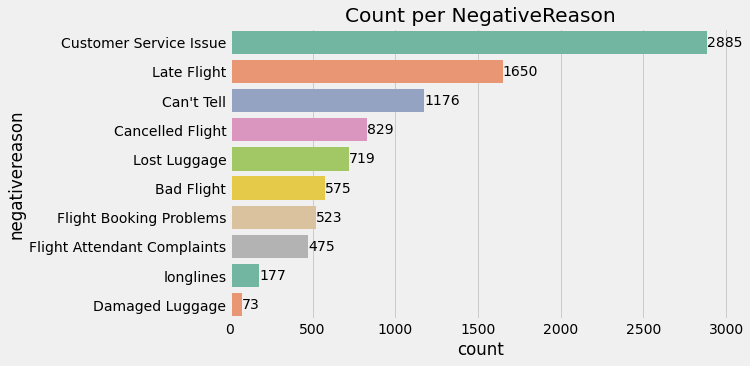

In [11]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')

plt.show()

<br>

Customer service issue, as a whole, is the main reason for the negative sentiment to the airlines.

The following is the detail sorted by airlines' name.

<br>

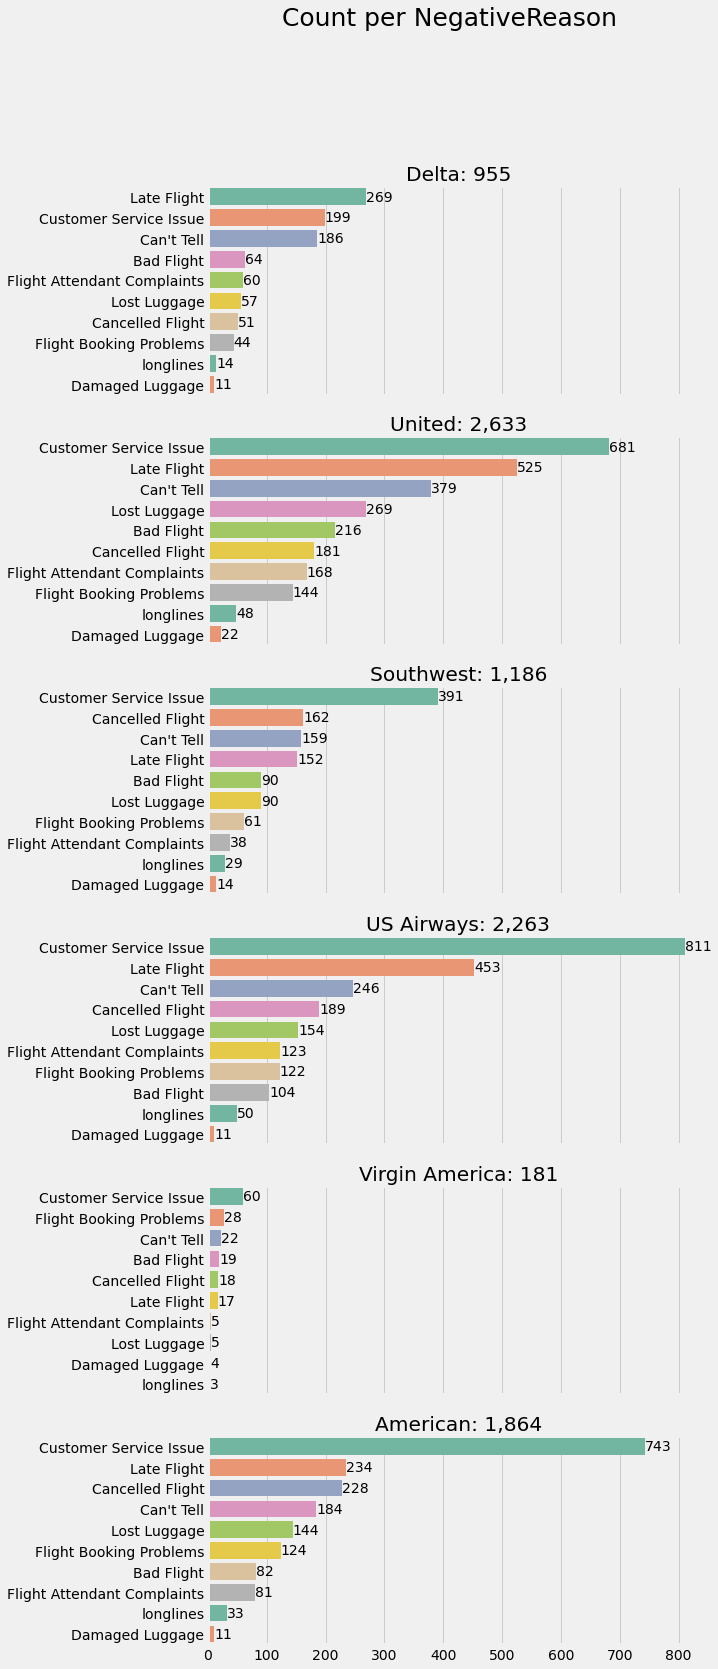

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = df_neg[df_neg.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = df_neg[df_neg.airline==name].negativereason.value_counts().index, ax = n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Count per NegativeReason", fontsize = 25)
plt.show()

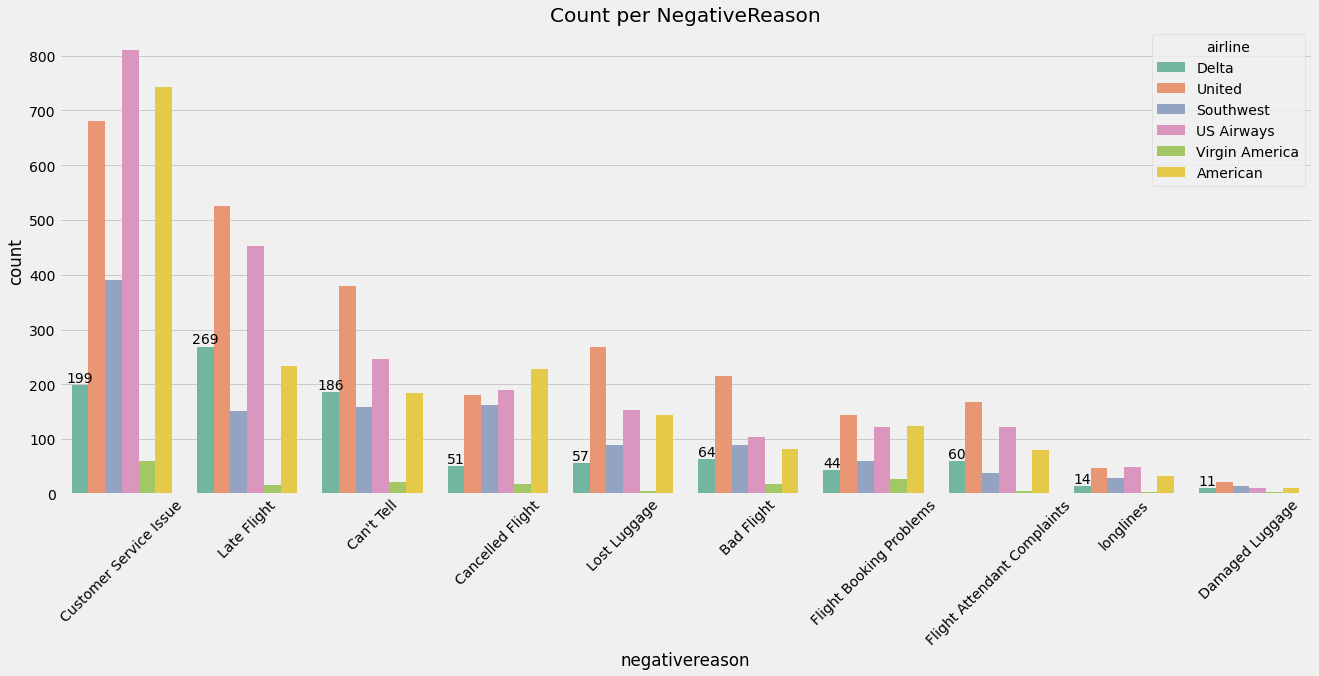

In [13]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = df_neg, x = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index, hue = 'airline')

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')
plt.xticks(rotation=45)
plt.show()

In [14]:
names = df.airline.unique()
for name in names:
    print(f"{name} : Out of total {format(len(df[df.airline == name]),',')}customers, {(len(df_neg[df_neg.airline == name]) / len(df[df.airline == name]))*100:.1f}% feel negative.\n")

Delta : Out of total 2,222customers, 43.0% feel negative.

United : Out of total 3,822customers, 68.9% feel negative.

Southwest : Out of total 2,420customers, 49.0% feel negative.

US Airways : Out of total 2,913customers, 77.7% feel negative.

Virgin America : Out of total 504customers, 35.9% feel negative.

American : Out of total 2,604customers, 71.6% feel negative.



<br>

* **`American`, `US Airways`, `Southwest`**: Complaints about customer sevice issue is relatively high.

* **`United`** : Customer service issue is the most, but customers for this airline experienced late flight more frequently than others. Lost luggage issue happened relatively high.

* **`Delta`**: Customer service looks not bad, but most of customers experienced late flight.

* **`Virgin America`**: Mostly about customer service followed by flight booking problem.

<br>

## Text Preprocessing 

* Tweet text is consisted of 103 length in average.
* Minimum length is 12, and maximum one is 186.

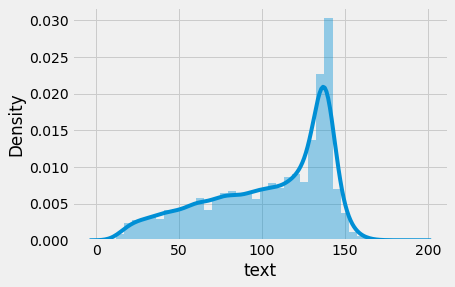

In [15]:
sns.distplot(df.text.str.len())

plt.show()

In [16]:
df.text.str.len().describe()

count    14485.000000
mean       103.836452
std         36.260307
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

### Procedure
* Regular expression
* Tokenization
* Checking Stopwords

In [17]:
# We will go over the sampled text as below.
# Every tweets share the common rule starting with @ + airlines' name.
# We can also see there are http formats, emojis, and hashtag

print(df.text[0].split(),'\n')
print(df.text[1].split(),'\n')
print(df.text[100].split(),'\n')
print(df.text[1000].split(),'\n')
print(df.text[10000].split())

["@JetBlue's", 'new', 'CEO', 'seeks', 'the', 'right', 'balance', 'to', 'please', 'passengers', 'and', 'Wall', '...', '-', 'Greenfield', 'Daily', 'Reporter', 'http://t.co/LM3opxkxch'] 

['@JetBlue', 'is', 'REALLY', 'getting', 'on', 'my', 'nerves', '!!', '😡😡', '#nothappy'] 

['@SouthwestAir', "I'm", 'an', 'A-list', 'Preferred', 'customer', 'and', 'very', 'loyal', 'SWA.', 'However,', 'your', 'inflight', 'wifi', 'is', 'no', 'better', 'today', 'than', 'it', 'was', '4', 'years', 'ago.'] 

['@SouthwestAir', 'I', 'got', 'it', 'added', 'thank', 'you!', ':)'] 

['@AmericanAir', 'lies,lies,lies.', 'Worst', 'travel', 'experience', 'of', 'my', 'life.', 'Day', '2', 'no', 'clothes', 'on', 'vaca.', '#lostluggage', '#unprofessional', '#pit', '#mia']


In [ ]:
# !pip install nltk

In [6]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# I thought the words related the name of airlines are not relevant to the sentiment analysis
# Therefore I decided to append the above names into the list of stop words.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0    [new, ceo, seeks, right, balance, please, pass...
1                  [really, getting, nerves, nothappy]
2    [yes, waited, line, almost, hour, passengers, ...
3    [got, gate, iah, time, given, seats, closed, k...
4    [cool, bags, take, bit, longer, dont, give, ba...
Name: final_text, dtype: object

In [21]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch 

really getting nerves nothappy 

im alist preferred customer loyal swa however inflight wifi better today years ago 

got added thank 

lieslieslies worst travel experience life day clothes vaca lostluggage unprofessional pit mia


<br>

## Text Analysis

### Lexicon based approach

The lexicon-based approach involves calculating orientation for a document from the semantic orientation of words or phrases in the document.it uses dictionaries of words annotated with the word's semantic orientation, or polarity.

Here we will just try to verify the lexicon works hopefully very well to classify the sentiment which has already been allocated by the real customers.

#### Vader

Vader is a lexicon made for the sentiment analysis of text data on social media.

It returns the compounded polarity score of a sentence after calculating the negative, the neutral, and the positive scores of each word in a sentence.

We can use Vader from the innner module in nltk as well as the Python API [vaderSentiment](https://pypi.org/project/vaderSentiment/).

VADER has many advantages over traditional sentiment analysis methods: [source](https://ichi.pro/ko/python-eseo-vaderleul-sayonghayeo-gamjeong-bunseog-dansunhwa-sosyeol-midieo-tegseuteu-274770204542255)

* **It works very well with social media type text**, but generalizes easily to multiple domains.
* It does not require any training data, but consists of a generalized, balence-based, human-curated gold standard psychological vocabulary.
* It's fast enough to use online with streaming data,
* The speed-performance trade-off isn't serious.



In [22]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182}

In [23]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.text[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.text[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.text[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.text[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

print(df.text[10000])
print(texts[10000])
print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')

@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch
new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182} --> Actual Classification: neutral 

@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy
really getting nerves nothappy
{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.1725} --> Actual Classification: negative 

Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
wanted get bag benefit instead get pricing three tickets adding card mp visa option
{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.4588} --> Actual Classification: negative 

@SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.
im alist preferred customer loyal swa h

<br>

We realize that some clear sentences could be classified as almost same as the actual classification.

But the very ambiguous(or sarcastic) senteces such as:
* Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
* @SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.

Sometimes Vader didn't work well to classify the real sentiment and this shows the limitation of current NLP and the way to go at the same time.


<br>

<br>

### WordCloud : Keyword analysis

WordCloud is one of the easiest way to show which word mainly(frequently) appears in the set of sentences.

But it can be just one of pieces of visulalization if there's no appropriate text preprocessing before drawing it. 

In [24]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = df[df.sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = df[df.sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = df[df.sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

114853 585364 149515


In [25]:
from wordcloud import WordCloud

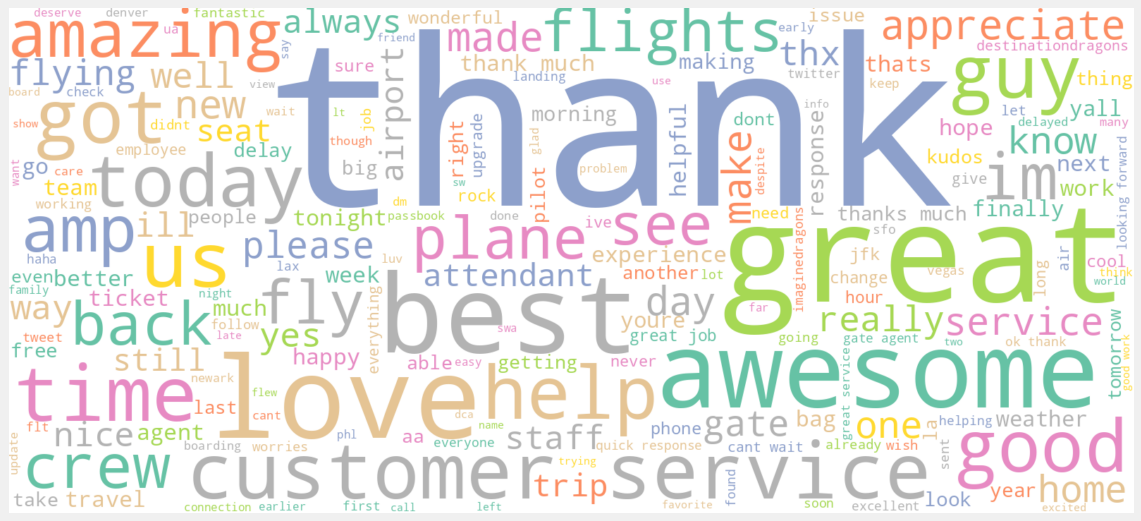

In [26]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

We can see many positive words such as 'thank', 'great', 'love', etc.

<br>

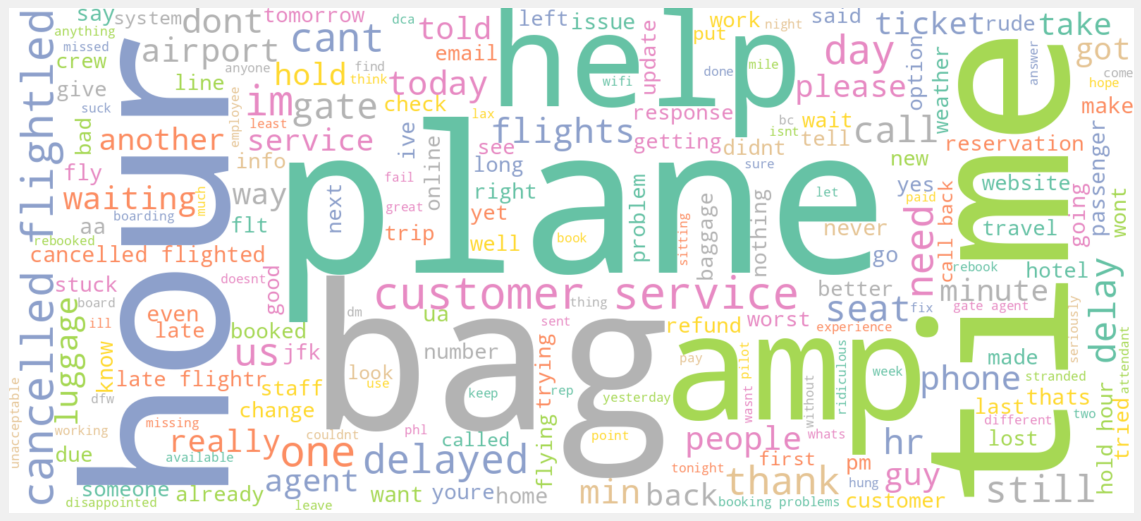

In [27]:
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

The main words we can see in the WC of negative sentiment is 'plane', 'bag', 'time', 'customer', 'service', etc.

<br>

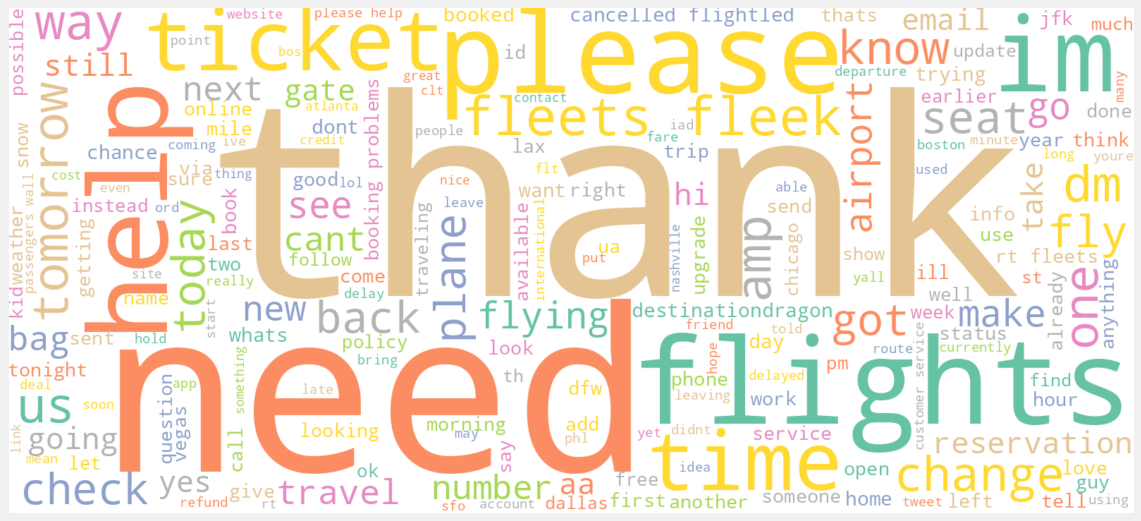

In [28]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

neutral is just neutral. The only positive word we can see at a glance is 'thank'.
Almost no negative and positive words.

<br>

<br>

### Machine Learning approach

ML approach is also known as Document Classificaton. It uses ML/DL algorithm to classify the text data.

The most important in ML approach is to convert the text to the vector or other numeric format to make the algorithms understand the text as a feature.


* Vectorization : `CountVectorizer`, `TfidfTransformer`, `Word2Vec`
* Model: Logistic Regression, RandomForest, MultinomialNB, SupportVectorMachine, BiLSTM

In [26]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [10]:
df.final_text

0        [new, ceo, seeks, right, balance, please, pass...
1                      [really, getting, nerves, nothappy]
2        [yes, waited, line, almost, hour, passengers, ...
3        [got, gate, iah, time, given, seats, closed, k...
4        [cool, bags, take, bit, longer, dont, give, ba...
                               ...                        
14480              [hope, fly, often, would, hate, change]
14481                     [dm, possible, arent, following]
14482    [yesterday, way, ewr, fll, takeoff, wheelsup, ...
14483                      [one, agents, available, speak]
14484    [better, time, call, friday, need, change, wor...
Name: final_text, Length: 14485, dtype: object

In [11]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [12]:
df['final_text'][:3]

0    new ceo seeks right balance please passengers ...
1                       really getting nerves nothappy
2    yes waited line almost hour passengers left wa...
Name: final_text, dtype: object

In [13]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
df.sentiment = df.sentiment.apply(lambda x : convert_Sentiment(x))

In [14]:
X = df.final_text
y = df.sentiment

<br>

#### CountVectorizer & TfidfVectorizer

In [47]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
              MultinomialNB(),
              SVC(**model_params)]
model_names = ['LogisticRegression', 'RandomForest', 'MultinomialNB', 'SupportVectorMachine']

c = CountVectorizer()
X_c = c.fit_transform(X)

tf = TfidfVectorizer()
X_tf = tf.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_names):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_c_trn = X_c[trn_idx]
        X_tf_trn = X_tf[trn_idx]
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_c_vld = X_c[vld_idx]
        X_tf_vld = X_tf[vld_idx]
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_c_trn, y_trn)
        c_pred_col = f"{model_name}_ct_pred"
        df.loc[vld_idx, c_pred_col] = model.predict(X_c_vld)
        
        model.fit(X_tf_trn, y_trn)
        tf_pred_col = f"{model_name}_tf_pred"
        df.loc[vld_idx, tf_pred_col] = model.predict(X_tf_vld)

    print(f"Model: {model_name}, CountVectorizer, Accuracy: {accuracy_score(df.sentiment, df[c_pred_col]):.3%}")
    print(f"Model: {model_name}, TfidfVectorizer, Accuracy: {accuracy_score(df.sentiment, df[tf_pred_col]):.3%}\n")

Model: LogisticRegression, CountVectorizer, Accuracy: 78.688%
Model: LogisticRegression, TfidfVectorizer, Accuracy: 76.652%

Model: RandomForest, CountVectorizer, Accuracy: 76.659%
Model: RandomForest, TfidfVectorizer, Accuracy: 76.748%

Model: MultinomialNB, CountVectorizer, Accuracy: 75.823%
Model: MultinomialNB, TfidfVectorizer, Accuracy: 68.526%

Model: SupportVectorMachine, CountVectorizer, Accuracy: 77.087%
Model: SupportVectorMachine, TfidfVectorizer, Accuracy: 76.534%



<br>

#### Word2Vec 

Word2Vec is one of the most popular model to represent a word in a large text corpus as a vector in n-dimensional space.

There are two kinds of W2V, Continuous Bag-of-Words(CBOW) and Skip-Gram.

Skip-gram is used to predict the context word for a given target word. It’s reverse of CBOW algorithm. Here, target word is input while context words are output.

In most case it is known that the predictability of skip-gram is better than the one of CBOW.

We can use `Word2Vec` library from `gensim` and set the option `sg` which is the abbreviation of skip-gram. 
    
* 1, if you want to set skip-gram and 0 for CBOW.

In [49]:
from gensim.models import Word2Vec

texts_w2v = df.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [51]:
texts_w2v[:3]

[['new',
  'ceo',
  'seeks',
  'right',
  'balance',
  'please',
  'passengers',
  'wall',
  'greenfield',
  'daily',
  'reporter',
  'httptcolmopxkxch'],
 ['really', 'getting', 'nerves', 'nothappy'],
 ['yes',
  'waited',
  'line',
  'almost',
  'hour',
  'passengers',
  'left',
  'wanting',
  'wait',
  'past']]

<br>

`Word2Vec` imported from `gensim` trains the texts at the same time as it is declared by the user. 

We can find the similar words with the given word and the examples are represented below.

<br>

In [52]:
w2v.wv.most_similar('thank')

[('much', 0.9774029850959778),
 ('thanks', 0.9619024395942688),
 ('appreciate', 0.957652747631073),
 ('awesome', 0.9506362676620483),
 ('quick', 0.947283923625946),
 ('amazing', 0.9390205144882202),
 ('care', 0.9260671734809875),
 ('response', 0.9206854701042175),
 ('twitter', 0.9195084571838379),
 ('customers', 0.9175267219543457)]

In [53]:
w2v.wv.most_similar('customerservice')

[('transferred', 0.9932414293289185),
 ('philadelphia', 0.9923903346061707),
 ('frustrating', 0.9923599362373352),
 ('fail', 0.9920975565910339),
 ('literally', 0.9919195175170898),
 ('cs', 0.9917356371879578),
 ('standing', 0.991335928440094),
 ('zero', 0.9901559352874756),
 ('apparently', 0.9901288151741028),
 ('speaking', 0.9898884892463684)]

In [54]:
w2v.wv.most_similar('crew')

[('ground', 0.9378228783607483),
 ('staff', 0.9096908569335938),
 ('attendant', 0.8983410000801086),
 ('landing', 0.891050398349762),
 ('pilot', 0.8888680934906006),
 ('ua', 0.87648606300354),
 ('san', 0.8735730051994324),
 ('communication', 0.8689080476760864),
 ('air', 0.8654320240020752),
 ('passengers', 0.8637962937355042)]

In [55]:
w2v.wv.most_similar('delay')

[('delayed', 0.91422039270401),
 ('tarmac', 0.8995780944824219),
 ('ua', 0.8946148157119751),
 ('sitting', 0.8943161368370056),
 ('issues', 0.8941435217857361),
 ('jfk', 0.8860460519790649),
 ('runway', 0.8854265809059143),
 ('stuck', 0.884270429611206),
 ('mechanical', 0.8730388879776001),
 ('pilot', 0.8730217814445496)]

In [56]:
w2v.wv.most_similar('bag')

[('bags', 0.9065929055213928),
 ('baggage', 0.9056369066238403),
 ('checked', 0.900001049041748),
 ('luggage', 0.8980709910392761),
 ('carry', 0.8651326298713684),
 ('claim', 0.8636552691459656),
 ('check', 0.8564242124557495),
 ('found', 0.8334078788757324),
 ('lose', 0.8314871788024902),
 ('lost', 0.8280549049377441)]

In [57]:
w2v.wv.most_similar('ticket')

[('fee', 0.9545719623565674),
 ('name', 0.9342708587646484),
 ('refund', 0.9245110154151917),
 ('add', 0.9215421676635742),
 ('booked', 0.9201467037200928),
 ('award', 0.9155846238136292),
 ('online', 0.9121180772781372),
 ('change', 0.9113159775733948),
 ('website', 0.9102339744567871),
 ('credit', 0.9078947305679321)]

In [58]:
w2v.wv.most_similar('booking')

[('reflight', 0.9043063521385193),
 ('problems', 0.7925882339477539),
 ('fee', 0.7769297957420349),
 ('options', 0.7314848303794861),
 ('system', 0.7259960174560547),
 ('travel', 0.7218188047409058),
 ('name', 0.7182386517524719),
 ('error', 0.7130455374717712),
 ('website', 0.7125111818313599),
 ('using', 0.7054314613342285)]

In [70]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.index_to_key:    # don't use .wv.vocab method in kaggle notebook. instead, use .wv.index_to_key method.
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
df['w2v_vector'] = df['final_text'].map(get_avg_vector)
df[['final_text', 'w2v_vector']].head(2)

,final_text,w2v_vector
0,new ceo seeks right balance please passengers ...,"[-0.045033276805447206, 0.05937890236317697, -..."
1,really getting nerves nothappy,"[-0.04141371697187424, 0.05362058764634033, -0..."


In [72]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
#               MultinomialNB(),  # Don't use Naive Bayes since w2v_vector contains negative numbers, then it causes an error.
              SVC(**model_params)]
model_name = ['LogisticRegression', 'RandomForest', 'SupportVectorMachine']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_trn = np.stack(df.loc[trn_idx, 'w2v_vector'])
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_vld = np.stack(df.loc[vld_idx, 'w2v_vector'])
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        df.loc[vld_idx, pred_col] = model.predict(X_vld)
        

    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(df.sentiment, df[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 71.405%

Model: RandomForest, Word2Vec, Accuracy: 72.592%

Model: SupportVectorMachine, Word2Vec, Accuracy: 70.307%



<br>

We found that the results aren't be improved on the traditional ML algorithms.

It is known that effect from using embedding vector like Word2Vec usually maximizes by using sequence model like RNN.

I will try BiLSTM.

<br>

#### LSTM 

In [8]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [15]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['final_text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['final_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch 

After Tokenization & Padding 
 [  68  484 1995  103 1594   18  115  668 1094    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [92]:
y = pd.get_dummies(df.sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8111, 100) (8111, 3)
Validation Set: (3477, 100) (3477, 3)
Test Set:       (2897, 100) (2897, 3)


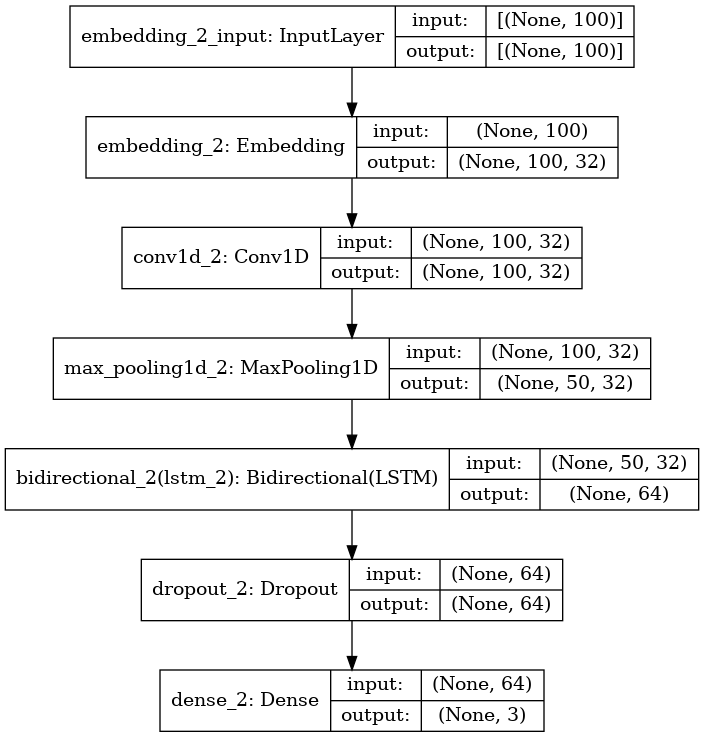

In [93]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
________________________________________________

In [95]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
127/127 [==============================] - 4s 15ms/step - loss: 0.8573 - accuracy: 0.6368 - val_loss: 0.7086 - val_accuracy: 0.6862
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 0.6072 - accuracy: 0.7351 - val_loss: 0.6226 - val_accuracy: 0.7466
Epoch 3/50
127/127 [==============================] - 1s 10ms/step - loss: 0.4695 - accuracy: 0.8089 - val_loss: 0.6276 - val_accuracy: 0.7561
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 0.3732 - accuracy: 0.8602 - val_loss: 0.6739 - val_accuracy: 0.7593
Epoch 5/50
127/127 [==============================] - 1s 11ms/step - loss: 0.3217 - accuracy: 0.8865 - val_loss: 0.7094 - val_accuracy: 0.7662
Epoch 6/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2381 - accuracy: 0.9158 - val_loss: 0.7931 - val_accuracy: 0.7604
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 0.1858 - accuracy: 0.9376 - val_loss: 0.8769 - val_accuracy: 0.7486

In [98]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.7570


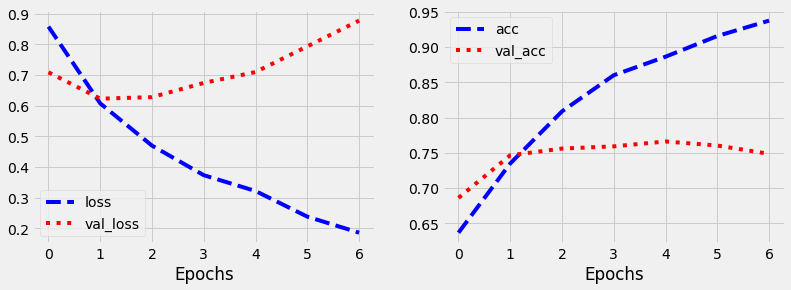

In [100]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

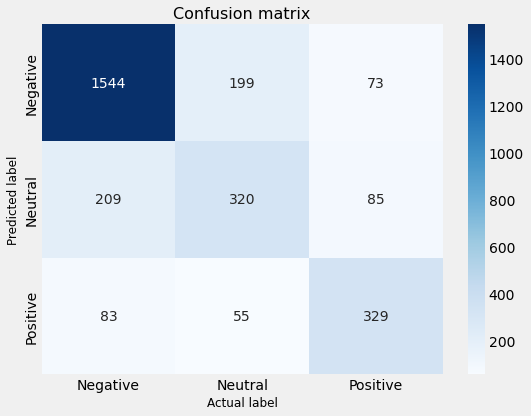

In [102]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

<br>

## Improvement

* Trying to use 'NegativeReason' feature to improve the predictivity of models.

In [22]:
df['final_text_2'] = df['negativereason'] + ' ' + df['final_text']
df[['final_text' , 'final_text_2']]

,final_text,final_text_2
0,new ceo seeks right balance please passengers ...,new ceo seeks right balance please passengers...
1,really getting nerves nothappy,Can't Tell really getting nerves nothappy
2,yes waited line almost hour passengers left wa...,Late Flight yes waited line almost hour passen...
3,got gate iah time given seats closed know peop...,Late Flight got gate iah time given seats clos...
4,cool bags take bit longer dont give baggage bl...,Customer Service Issue cool bags take bit long...
...,...,...
14480,hope fly often would hate change,hope fly often would hate change
14481,dm possible arent following,dm possible arent following
14482,yesterday way ewr fll takeoff wheelsup jetblue...,yesterday way ewr fll takeoff wheelsup jetblu...
14483,one agents available speak,Customer Service Issue one agents available speak


In [23]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['final_text_2'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['final_text_2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
  new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch 

After Tokenization & Padding 
 [  79  489 1998  112 1597   29  123  673 1098    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [27]:
# y = pd.get_dummies(df.sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8111, 100) (8111, 3)
Validation Set: (3477, 100) (3477, 3)
Test Set:       (2897, 100) (2897, 3)


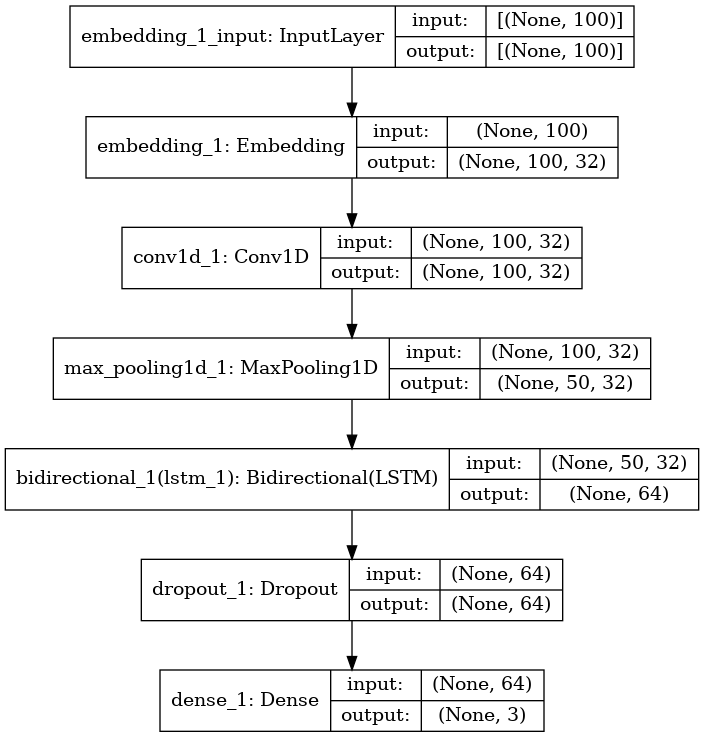

In [29]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
________________________________________________

In [31]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

2022-02-14 05:26:40.789042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-14 05:26:44.428110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


127/127 [==============================] - 11s 15ms/step - loss: 0.6013 - accuracy: 0.7241 - val_loss: 0.2942 - val_accuracy: 0.8303
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2566 - accuracy: 0.8596 - val_loss: 0.2145 - val_accuracy: 0.9005
Epoch 3/50
127/127 [==============================] - 1s 12ms/step - loss: 0.1786 - accuracy: 0.9340 - val_loss: 0.1654 - val_accuracy: 0.9310
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0993 - accuracy: 0.9662 - val_loss: 0.1909 - val_accuracy: 0.9252
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0736 - accuracy: 0.9769 - val_loss: 0.2133 - val_accuracy: 0.9206
Epoch 6/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0576 - accuracy: 0.9824 - val_loss: 0.2180 - val_accuracy: 0.9246
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0474 - accuracy: 0.9862 - val_loss: 0.2411 - val_accuracy: 0.9198
Epoch 8/5

In [32]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.9251


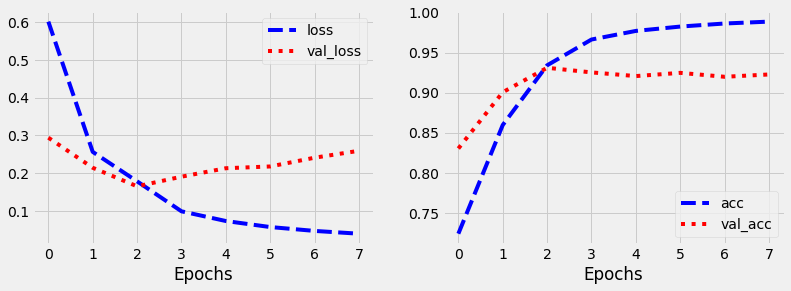

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

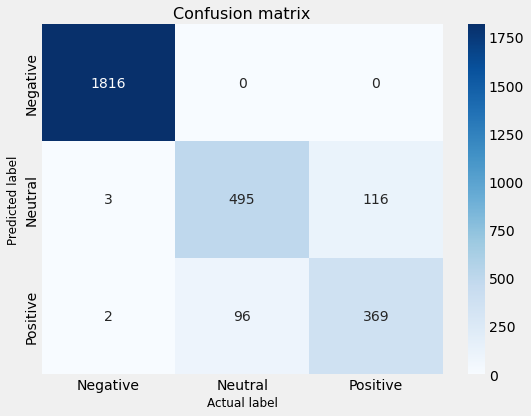

In [34]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

<br>

We were able to improve the predictability of our LSTM model just after merging the keyword of negative reason with the preprocessed texts.

As we can see in the confusion matrix, the Recall score of each class has also been highly imporved.

In [35]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


<br>

## Test with another tweets dataset

* There is another Tweets.csv dataset and I will try to classify the sentiment of this text data with the previous model.

In [36]:
model = load_model('best_model.h5')

In [38]:
df_new = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')

df_new.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [40]:
df_new['final_text']= df_new.text.apply(clean_text).apply(clean_stopword).apply(tokenize)

for i in range(len(df_new)):
    df_new['final_text'][i] = " ".join(df_new['final_text'][i])

df_new.final_text.head()

0                                        dhepburn said
1        plus youve added commercials experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: final_text, dtype: object

In [42]:
df_new['final_text_2'] = df_new['negativereason'].fillna('') + ' ' + df_new['final_text']
df_new[['final_text' , 'final_text_2']]

,final_text,final_text_2
0,dhepburn said,dhepburn said
1,plus youve added commercials experience tacky,plus youve added commercials experience tacky
2,didnt today must mean need take another trip,didnt today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...,Bad Flight really aggressive blast obnoxious e...
4,really big bad thing,Can't Tell really big bad thing
...,...,...
14635,thank got different chicago,thank got different chicago
14636,leaving minutes late warnings communication mi...,Customer Service Issue leaving minutes late wa...
14637,please bring blackberry,please bring blackberry
14638,money change dont answer phones suggestions ma...,Customer Service Issue money change dont answe...


In [44]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
df_new.airline_sentiment = df_new.airline_sentiment.apply(lambda x : convert_Sentiment(x))

In [45]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df_new['final_text_2'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df_new['final_text_2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
  dhepburn said 

After Tokenization & Padding 
 [132   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [46]:
y = pd.get_dummies(df_new.airline_sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8198, 100) (8198, 3)
Validation Set: (3514, 100) (3514, 3)
Test Set:       (2928, 100) (2928, 3)


In [52]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
129/129 [==============================] - 4s 15ms/step - loss: 0.6186 - accuracy: 0.7133 - val_loss: 0.2865 - val_accuracy: 0.8315
Epoch 2/50
129/129 [==============================] - 1s 10ms/step - loss: 0.2532 - accuracy: 0.8652 - val_loss: 0.2067 - val_accuracy: 0.9126
Epoch 3/50
129/129 [==============================] - 2s 12ms/step - loss: 0.1392 - accuracy: 0.9477 - val_loss: 0.1758 - val_accuracy: 0.9274
Epoch 4/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0914 - accuracy: 0.9691 - val_loss: 0.1998 - val_accuracy: 0.9274
Epoch 5/50
129/129 [==============================] - 2s 13ms/step - loss: 0.0604 - accuracy: 0.9816 - val_loss: 0.2102 - val_accuracy: 0.9240
Epoch 6/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.2327 - val_accuracy: 0.9226
Epoch 7/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0351 - accuracy: 0.9899 - val_loss: 0.2705 - val_accuracy: 0.9197

In [53]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.9191


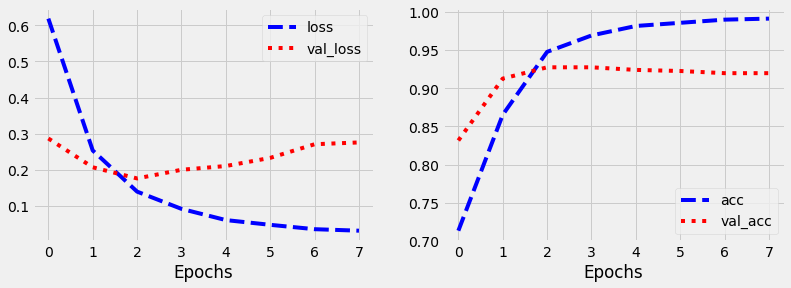

In [54]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

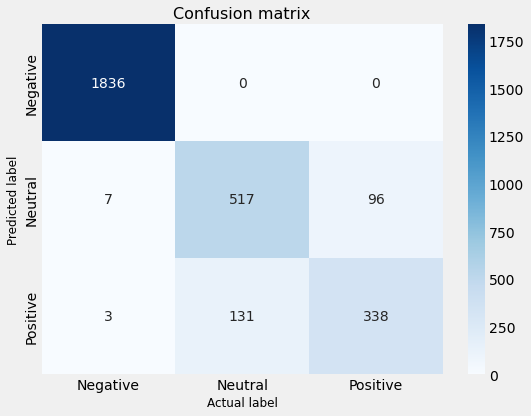

In [55]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)